## Convolution 1D

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from activation import ReLU, TanH, Sigmoid
from convolution.conv1D import Conv1D, ConvTranspose1D, DoubleConv1D, AvgPool1D, Flatten, MaxPool1D
from enums import GradientDescentMode
from linear import Linear
from loss import CELoss, MSELoss
from module import Module
from sequential import Sequential
from optimizers import SGD
from utils import onehot_encoding

from sklearn import datasets
from sklearn.model_selection import train_test_split

### Série temporelle : Air Passengers

In [3]:
import pandas as pd

In [4]:
air_passengers_df = pd.read_csv('data/AirPassengers.csv')
air_passengers_df.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [5]:
data = air_passengers_df['#Passengers'].values.astype('float32')

# Normalisation des données
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data.reshape(-1, 1))
data[:10]

array([[-0.9691119 ],
       [-0.94594586],
       [-0.89189184],
       [-0.9034748 ],
       [-0.9343629 ],
       [-0.8803088 ],
       [-0.8301158 ],
       [-0.8301158 ],
       [-0.8764478 ],
       [-0.9420849 ]], dtype=float32)

In [6]:
# Préparation des données en séquences
seq_len = 12
x_data = []
y_data = []
for i in range(len(data)-seq_len-1):
    x = data[i:(i+seq_len)]
    y = data[i+seq_len]
    x_data.append(x)
    y_data.append(y)

x_data = np.array(x_data)
y_data = np.array(y_data).squeeze()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((104, 12, 1), (27, 12, 1), (104,), (27,))

In [8]:
k_size = 3
c_out = 1

net = Sequential(
    Conv1D(k_size, 1, 1, 1),
    Flatten(),
    Linear(seq_len-k_size+1, c_out)
)

lr = 1e-1
epochs = 1000
loss = MSELoss()

all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    x_train,
    y_train,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    None,
    x_test,
    y_test
)

Train : -----------------------------------
Epoch 100: train loss: 0.19627099076097893 val loss: 0.1962003807143217
Epoch 200: train loss: 0.19625034809823505 val loss: 0.1961823929423336
Epoch 300: train loss: 0.19622970858794886 val loss: 0.19616440743897154
Epoch 400: train loss: 0.1962090722295395 val loss: 0.19614642419866937
Epoch 500: train loss: 0.19618843902242633 val loss: 0.1961284432210647
Epoch 600: train loss: 0.19616780896602853 val loss: 0.19611046450579483
Epoch 700: train loss: 0.19614718205976575 val loss: 0.1960924880524974
Epoch 800: train loss: 0.1961265583030576 val loss: 0.19607451386081
Epoch 900: train loss: 0.19610593769532383 val loss: 0.1960565419303703
Epoch 1000: train loss: 0.19608532023598427 val loss: 0.19603857226081609
-------------------------------------------


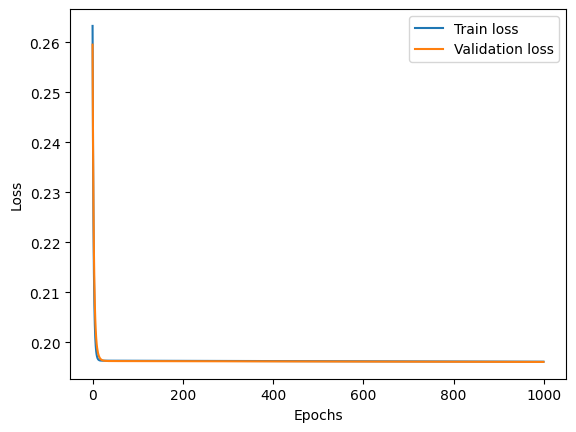

In [9]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Digits

In [10]:
digits = datasets.load_digits()

print('Nombre d exemples :', len(digits.data))
print('Nombre de features :', len(digits.feature_names))
print('Nombre de classes :', len(digits.target_names))

Nombre d exemples : 1797
Nombre de features : 64
Nombre de classes : 10


In [11]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=.2)
print('Données d apprentissage :', X_train.shape, y_train.shape)
print('Données de test :', X_test.shape, y_test.shape)

Données d apprentissage : (1437, 64) (1437,)
Données de test : (360, 64) (360,)


In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape, X_test.shape

((1437, 64, 1), (360, 64, 1))

In [13]:
y_train_onehot = onehot_encoding(y_train, 10)
y_test_onehot = onehot_encoding(y_test, 10)
print('One hot train :', y_train_onehot.shape)
print('One hot test :', y_test_onehot.shape)

One hot train : (1437, 10)
One hot test : (360, 10)


In [14]:
def eval_fn(net, X_test, y_test):
    y_pred = net(X_test).argmax(1)
    y_test = y_test.argmax(1)
    return np.mean(y_pred == y_test)

#### Conv1D

In [15]:
net = Sequential(
    Conv1D(3, 1, 32, 1),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(992, 100),
    ReLU(),
    Linear(100, 10)
)

lr = 1e-1
epochs = 10
loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    X_train,
    y_train_onehot,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    X_test,
    y_test_onehot
)

Train : -----------------------------------
Epoch 1: train loss: 2.427405862476154 val loss: 2.1864244326367297 val eval_fn: 0.26666666666666666
Epoch 2: train loss: 2.162185172333723 val loss: 2.0369355970867002 val eval_fn: 0.38055555555555554
Epoch 3: train loss: 1.9971680055182495 val loss: 1.890278193198013 val eval_fn: 0.5166666666666667
Epoch 4: train loss: 1.8537710046303286 val loss: 1.7766655650704375 val eval_fn: 0.625
Epoch 5: train loss: 1.7302916175106 val loss: 1.6684343296041797 val eval_fn: 0.5444444444444444
Epoch 6: train loss: 1.63136035854512 val loss: 1.6408901179787063 val eval_fn: 0.625
Epoch 7: train loss: 1.5868295743316603 val loss: 1.5101004676705863 val eval_fn: 0.5583333333333333
Epoch 8: train loss: 1.4840803050356548 val loss: 1.5013708038003604 val eval_fn: 0.5861111111111111
Epoch 9: train loss: 1.440478594493436 val loss: 1.3447458613369692 val eval_fn: 0.6972222222222222
Epoch 10: train loss: 1.3459848243116737 val loss: 1.276630160483634 val eval_fn

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(net, X, y):
    y_pred = net(X).argmax(1)
    cm = confusion_matrix(y, y_pred)
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

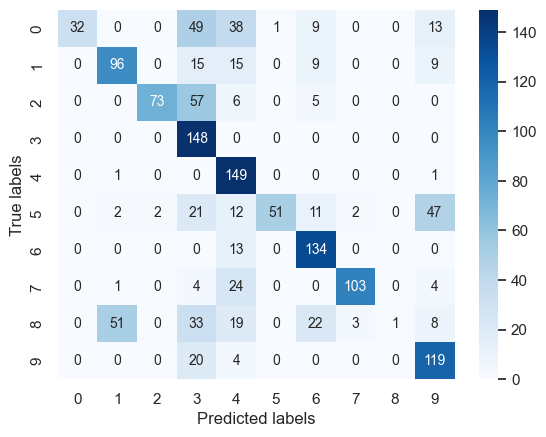

In [17]:
plot_confusion_matrix(net, X_train, y_train)

In [18]:
print('Train accuracy :', eval_fn(net, X_train, y_train_onehot))

Train accuracy : 0.6304801670146137


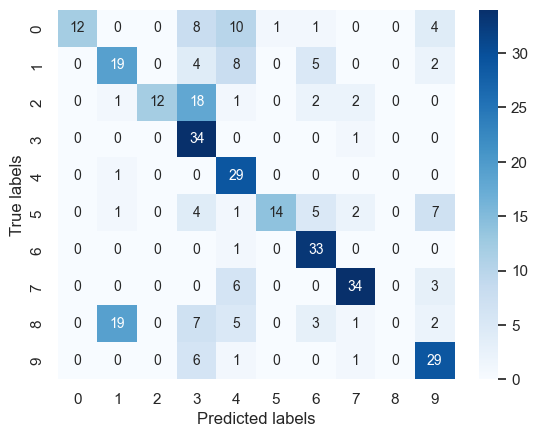

In [19]:
plot_confusion_matrix(net, X_test, y_test)

In [20]:
print('Test accuracy :', eval_fn(net, X_test, y_test_onehot))

Test accuracy : 0.6


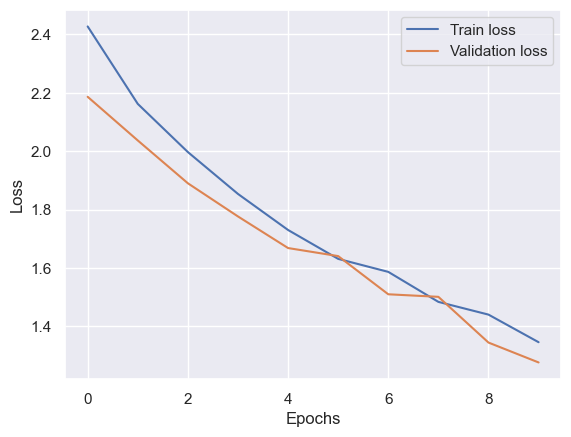

In [21]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

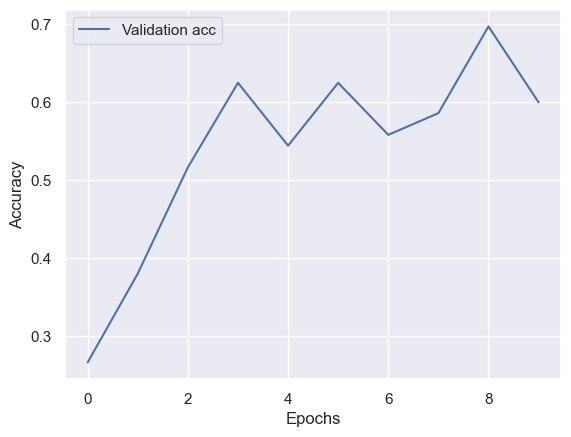

In [22]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Conv Transpose 1D

In [23]:
net = Sequential(
    ConvTranspose1D(3, 1, 32, 1, width=8, height=8),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(992, 100),
    ReLU(),
    Linear(100, 10)
)

lr = 1e-1
epochs = 1_000
loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    X_train,
    y_train_onehot,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    X_test,
    y_test_onehot
)

Train : -----------------------------------
Epoch 100: train loss: 0.11727348469551728 val loss: 0.14650024741729814 val eval_fn: 0.9722222222222222


KeyboardInterrupt: 

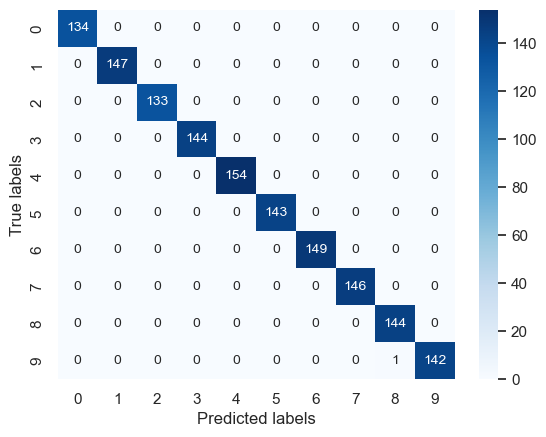

In [ ]:
plot_confusion_matrix(net, X_train, y_train)

In [28]:
print('Train accuracy :', eval_fn(net, X_train, y_train_onehot))

Train accuracy : 0.9993041057759221


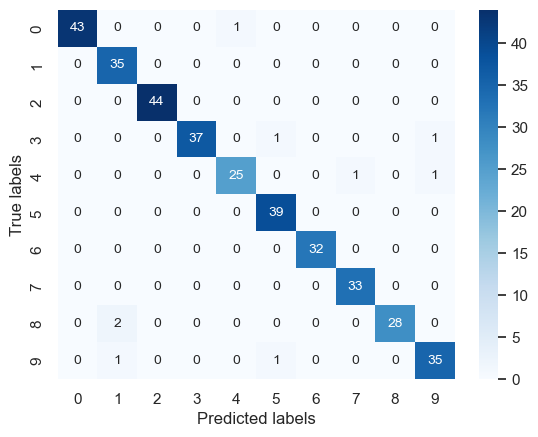

In [29]:
plot_confusion_matrix(net, X_test, y_test)

In [30]:
print('Test accuracy :', eval_fn(net, X_test, y_test_onehot))

Test accuracy : 0.975


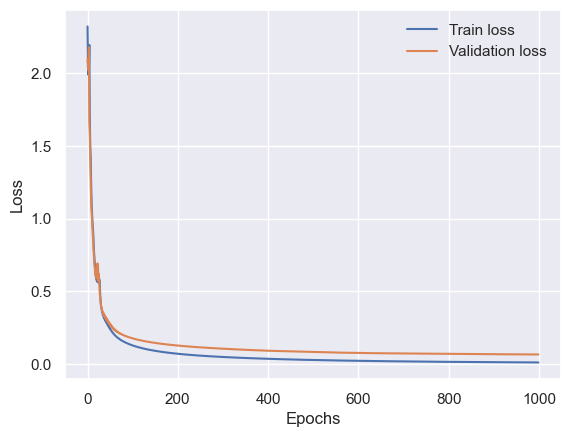

In [31]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

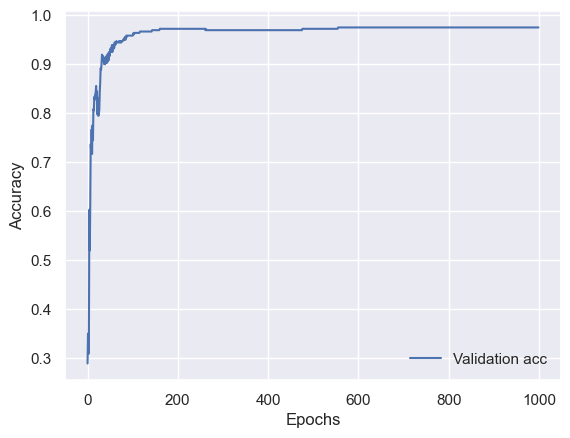

In [32]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Average pooling

In [34]:
net = Sequential(
    Conv1D(3, 1, 32, 1),
    AvgPool1D(2, 2),
    Flatten(),
    Linear(992, 100),
    ReLU(),
    Linear(100, 10)
)

lr = 1e-1
epochs = 1_000
loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    X_train,
    y_train_onehot,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    X_test,
    y_test_onehot
)

Train : -----------------------------------
Epoch 100: train loss: 0.1614104290730541 val loss: 0.20351606416008705 val eval_fn: 0.9527777777777777
Epoch 200: train loss: 0.09165746213522204 val loss: 0.14708149172965834 val eval_fn: 0.9694444444444444
Epoch 300: train loss: 0.0677636680207051 val loss: 0.1297424497540742 val eval_fn: 0.9694444444444444
Epoch 400: train loss: 0.05351735787206533 val loss: 0.11903051338732315 val eval_fn: 0.9694444444444444
Epoch 500: train loss: 0.04365210331621853 val loss: 0.11126357739677648 val eval_fn: 0.9694444444444444
Epoch 600: train loss: 0.03627680170000718 val loss: 0.10501077890435187 val eval_fn: 0.9694444444444444
Epoch 700: train loss: 0.03058558822233427 val loss: 0.10024657286641556 val eval_fn: 0.9694444444444444
Epoch 800: train loss: 0.02605818606955424 val loss: 0.09706810059997487 val eval_fn: 0.9666666666666667
Epoch 900: train loss: 0.02243856933397321 val loss: 0.09484047975766635 val eval_fn: 0.9666666666666667
Epoch 1000: tr

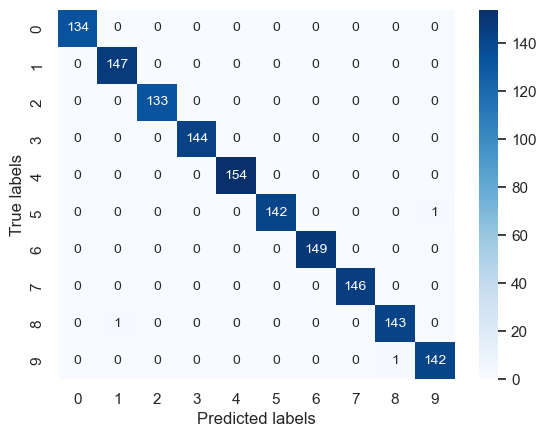

In [35]:
plot_confusion_matrix(net, X_train, y_train)

In [36]:
print('Train accuracy :', eval_fn(net, X_train, y_train_onehot))

Train accuracy : 0.9979123173277662


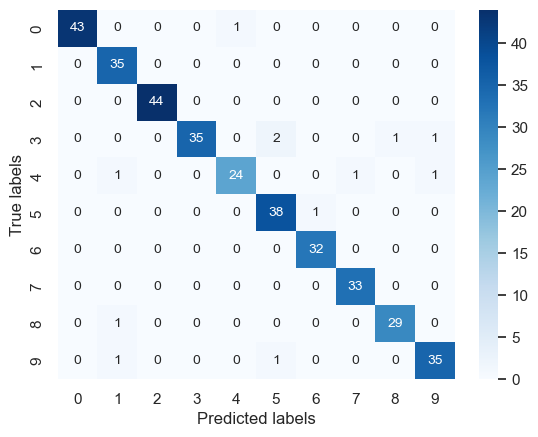

In [37]:
plot_confusion_matrix(net, X_test, y_test)

In [38]:
print('Test accuracy :', eval_fn(net, X_test, y_test_onehot))

Test accuracy : 0.9666666666666667


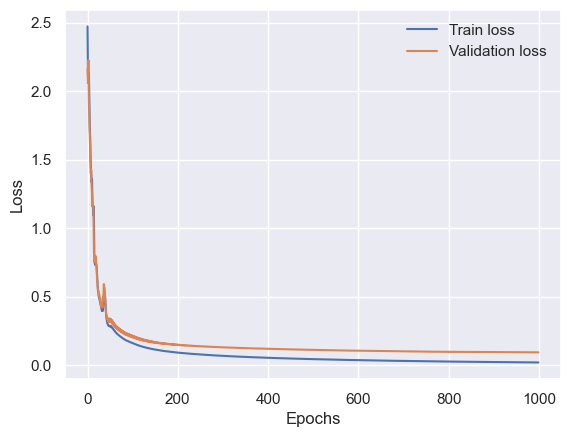

In [39]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

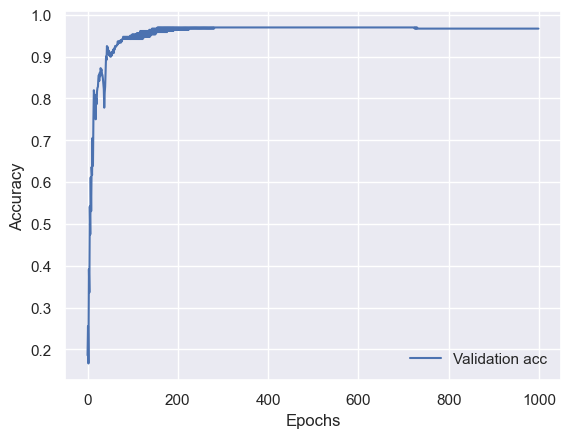

In [40]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
net = Sequential(
    Conv1D(3, 1, 32, 1),
    AvgPool1D(2, 2),
    Flatten(),
    Linear(992, 100),
    TanH(),
    Linear(100, 10)
)

lr = 1e-1
epochs = 1_000
loss = CELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    X_train,
    y_train_onehot,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    X_test,
    y_test_onehot
)

Train : -----------------------------------
Epoch 100: train loss: 0.17662400678295848 val loss: 0.21774258140332634 val eval_fn: 0.95
Epoch 200: train loss: 0.11005487816182961 val loss: 0.1627794828780602 val eval_fn: 0.9611111111111111
Epoch 300: train loss: 0.08189265257653754 val loss: 0.14027686995104238 val eval_fn: 0.9638888888888889
Epoch 400: train loss: 0.0650702420986932 val loss: 0.12654312226030093 val eval_fn: 0.9666666666666667
Epoch 500: train loss: 0.053511088055777936 val loss: 0.11658635295611267 val eval_fn: 0.9722222222222222
Epoch 600: train loss: 0.04496734412167221 val loss: 0.10882624332758793 val eval_fn: 0.9722222222222222
Epoch 700: train loss: 0.038379791832198494 val loss: 0.10264910865440637 val eval_fn: 0.9722222222222222
Epoch 800: train loss: 0.03316921111490705 val loss: 0.09772938700164373 val eval_fn: 0.9722222222222222
Epoch 900: train loss: 0.028981422861084526 val loss: 0.09382893904849432 val eval_fn: 0.9694444444444444
Epoch 1000: train loss: 

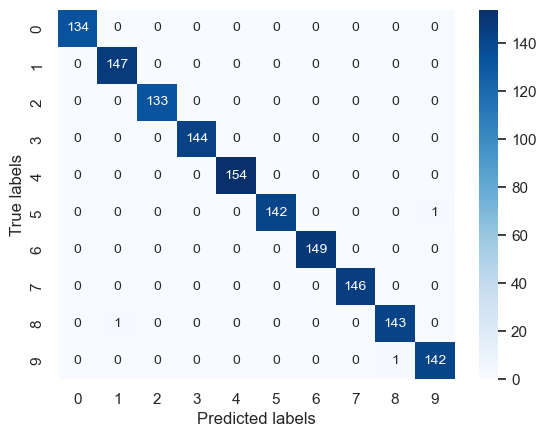

In [42]:
plot_confusion_matrix(net, X_train, y_train)

In [43]:
print('Train accuracy :', eval_fn(net, X_train, y_train_onehot))

Train accuracy : 0.9979123173277662


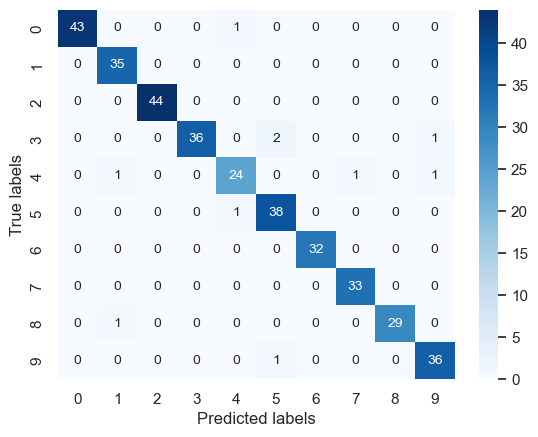

In [44]:
plot_confusion_matrix(net, X_test, y_test)

In [45]:
print('Train accuracy :', eval_fn(net, X_test, y_test_onehot))

Train accuracy : 0.9722222222222222


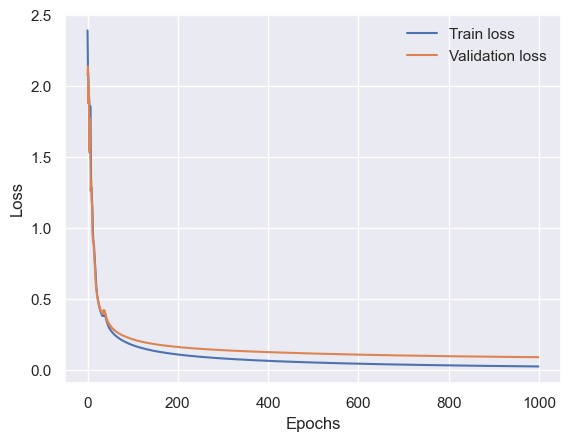

In [46]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

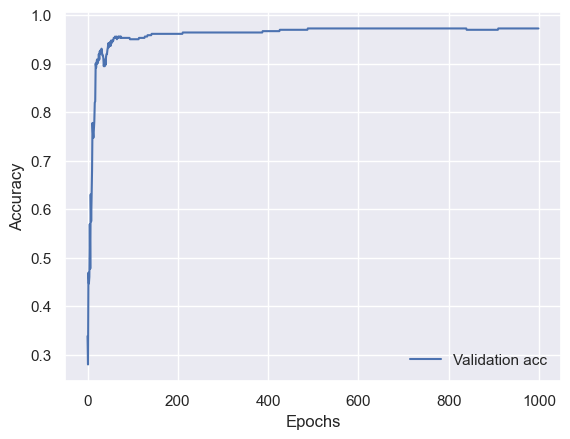

In [47]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()